In [1]:
import sys
import os
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")

from analysis_helpers import poisson_waiting_function, \
                            run_multiple_trajectories, \
                            plot_aip_vs_t, \
                            plot_cip_vs_t, \
                            run_sensitivity_sims, \
                            extract_cips

In [2]:
# what percent of self-reports are from severe symptoms?  
# in reality I think this value will vary a lot in the first few days, 
# and then reach some kind of steady-state, and I'm not sure what makes the most
# sense to use here.  I am setting it to the very pessimistic value of 100% of
# self-reporters are severe, which yields the smallest infectious window size
pct_self_reports_severe = 0.6

daily_self_report_severe = 0.85
daily_self_report_mild = 0.1

# avg_infectious_window = (avg time in ID state) + (avg time in Sy state prior to self-reporting)
avg_infectious_window = 4 + pct_self_reports_severe * (1 / daily_self_report_severe) + \
                        (1-pct_self_reports_severe) * (1 / daily_self_report_mild)
print(avg_infectious_window)
pre_reopen_population = 1500
pre_reopen_daily_contacts = 7

reopen_population = 2500
reopen_daily_contacts = 10

pre_reopen_params = {
    'max_time_exposed': 4,
    'exposed_time_function': poisson_waiting_function(max_time=4, mean_time=1),
    
    'max_time_pre_ID': 4,
    'pre_ID_time_function': poisson_waiting_function(max_time=4, mean_time=1),
    
    'max_time_ID': 8,
    'ID_time_function': poisson_waiting_function(max_time=8, mean_time=4),
    
    'max_time_SyID_mild': 14,
    'SyID_mild_time_function': poisson_waiting_function(max_time=14, mean_time=10),
    
    'max_time_SyID_severe': 14,
    'SyID_severe_time_function': poisson_waiting_function(max_time=14, mean_time=10),
    
    'sample_QI_exit_function': (lambda n: np.random.binomial(n, 0.05)),
    'sample_QS_exit_function': (lambda n: np.random.binomial(n, 0.3)),
    
    'exposed_infection_p': 0.026,
    'expected_contacts_per_day': pre_reopen_daily_contacts,
    
    'mild_symptoms_p': 0.4,
    'mild_symptoms_daily_self_report_p': daily_self_report_mild,
    'severe_symptoms_daily_self_report_p': daily_self_report_severe,
    
    'days_between_tests': 300,
    'test_population_fraction': 0,
    
    'test_protocol_QFNR': 0.1,
    'test_protocol_QFPR': 0.005,
    
    'perform_contact_tracing': True,
    'contact_tracing_constant': 0.5,
    'contact_tracing_delay': 1,
    'contact_trace_infectious_window': avg_infectious_window,
    
    'pre_ID_state': 'detectable',
    
    'population_size': pre_reopen_population,
    'initial_E_count': 0,
    'initial_pre_ID_count': 2,
    'initial_ID_count': 0,
    'initial_ID_prevalence': 0.001,
    'initial_SyID_mild_count': 0,
    'initial_SyID_severe_count': 0
}

reopen_params = pre_reopen_params.copy()
reopen_params['population_size'] = reopen_population
reopen_params['expected_contacts_per_day'] = reopen_daily_contacts

8.705882352941178


# Run sims to understand sensitivity of 'contact_tracing_constant'

In [4]:
ctc_range = [0.1 * x for x in range(11)]
dfs_ctc_pre_reopen = run_sensitivity_sims(pre_reopen_params, param_to_vary='contact_tracing_constant',
                                     param_values = ctc_range, trajectories_per_config=250, time_horizon=100)
dfs_ctc_post_reopen = run_sensitivity_sims(reopen_params, param_to_vary='contact_tracing_constant',
                                     param_values = ctc_range, trajectories_per_config=250, time_horizon=100)

Done simulating contact_tracing_constant equal to 0.0
Done simulating contact_tracing_constant equal to 0.1
Done simulating contact_tracing_constant equal to 0.2
Done simulating contact_tracing_constant equal to 0.30000000000000004
Done simulating contact_tracing_constant equal to 0.4
Done simulating contact_tracing_constant equal to 0.5
Done simulating contact_tracing_constant equal to 0.6000000000000001
Done simulating contact_tracing_constant equal to 0.7000000000000001
Done simulating contact_tracing_constant equal to 0.8
Done simulating contact_tracing_constant equal to 0.9
Done simulating contact_tracing_constant equal to 1.0
Done simulating contact_tracing_constant equal to 0.0
Done simulating contact_tracing_constant equal to 0.1
Done simulating contact_tracing_constant equal to 0.2
Done simulating contact_tracing_constant equal to 0.30000000000000004
Done simulating contact_tracing_constant equal to 0.4
Done simulating contact_tracing_constant equal to 0.5
Done simulating cont

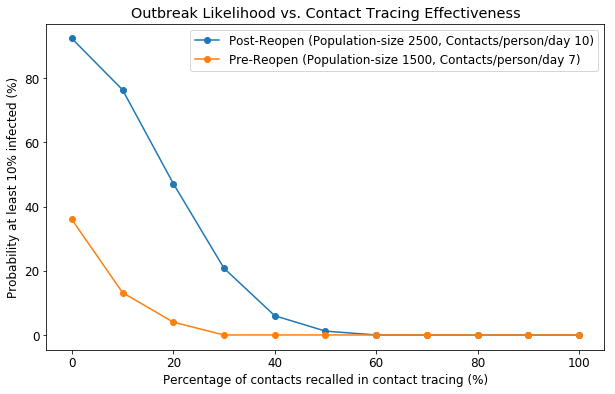

In [9]:
import matplotlib.pyplot as plt
def plot_many_dfs_threshold(dfs_dict, threshold=0.1, xlabel="", title="", figsize=(10,6)):
    plt.figure(figsize=figsize)
    for df_label, dfs_varied in dfs_dict.items():
        p_thresholds = []
        xs = sorted(list(dfs_varied.keys()))
        for x in xs:
            cips = extract_cips(dfs_varied[x])
            cip_exceed_thresh = [cip for cip in cips if cip >= threshold]
            p_thresholds.append(len(cip_exceed_thresh) / len(cips) * 100)
        plt.plot([x * 100 for x in xs], p_thresholds, marker='o', label=df_label)
    plt.xlabel(xlabel)
    plt.ylabel("Probability at least {:.0f}% infected (%)".format(threshold * 100))
    plt.title(title)
    plt.legend(loc='best')
    plt.show()

title = """Outbreak Likelihood vs. Contact Tracing Effectiveness"""
plot_many_dfs_threshold({'Post-Reopen (Population-size 2500, Contacts/person/day 10)': dfs_ctc_post_reopen,
                         'Pre-Reopen (Population-size 1500, Contacts/person/day 7)': dfs_ctc_pre_reopen, 
                         }, 
                        xlabel="Percentage of contacts recalled in contact tracing (%)",
                       title=title)